# Система прогноза оттока клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier as lgb
import lightgbm as lgbt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.dummy import DummyClassifier
from optuna.visualization.matplotlib import plot_param_importances
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from copy import deepcopy
# from  sklearn.neighbors import KNeighborsClassifier

In [5]:
# установка параметров системы
pd.options.display.max_columns = 100  # чтоб выводил все столбцы на экран
pd.options.display.float_format = '{:,.4f}'.format # отображение количества знаков после запятой

## Изучение данных

In [6]:
try:
    df = pd.read_csv(
        "https://code.s3.yandex.net/datasets/Churn.csv"
    )  # скачиваем датасет
except:
    print("ошибка связи с сетью")
try:
    df = pd.read_csv("/datasets/Churn.csv")  # если нет интернета
except:
    print("ошибка чтения с диска")

df_raw = df.copy()  # сохраняем сырые данные на случай дальнейших изменений датасета

ошибка чтения с диска


Получим общую информацию о таблице:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Есть возможность ускорить обучение моделей, изменив тип данных с 64 битных на 32.

Итак, согласно документации к данным:

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата

Целевой столбец:

    Exited — факт ухода клиента


Выведем на экран первые пять строк таблицы:

In [8]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0000,0.0000,1,1,1,"101,348.8800",1
1,2,15647311,Hill,608,Spain,Female,41,1.0000,"83,807.8600",1,0,1,"112,542.5800",0
2,3,15619304,Onio,502,France,Female,42,8.0000,"159,660.8000",3,1,0,"113,931.5700",1
3,4,15701354,Boni,699,France,Female,39,1.0000,0.0000,2,0,0,"93,826.6300",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0000,"125,510.8200",1,1,1,"79,084.1000",0


Построим гистограммы для числовых данных таблиц:

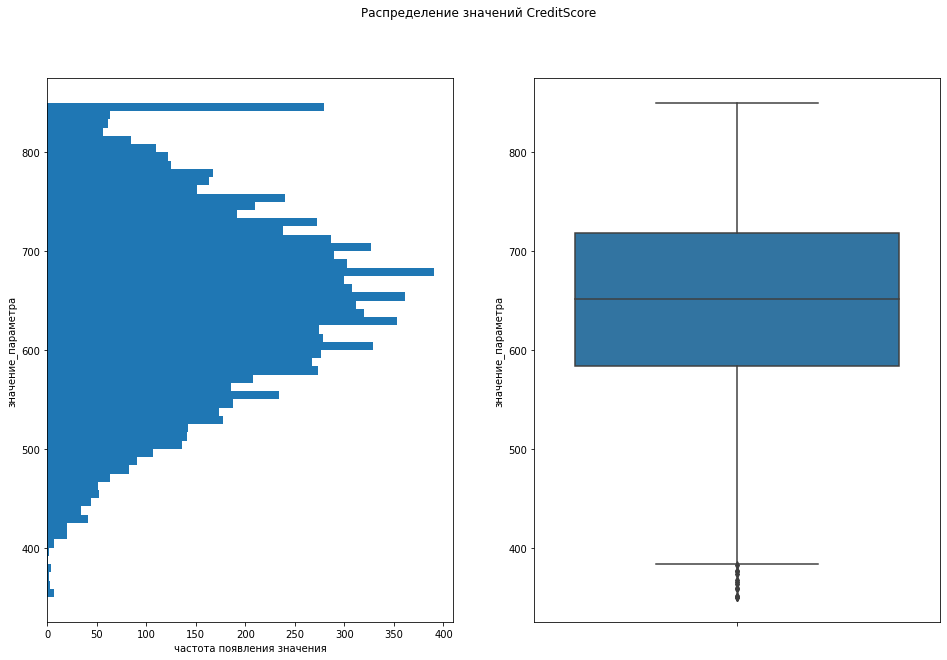

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
fig.suptitle("Распределение значений CreditScore")
y = df["CreditScore"]
ax[0].set_xlabel("частота появления значения")
ax[0].set_ylabel("значение_параметра")
ax[1].set_ylabel("значение_параметра")
ax[0].hist(y, orientation="horizontal", bins=60)
sns.boxplot(data=y, orient="v", ax=ax[1])
ax[1].set_xticklabels([])
plt.show()

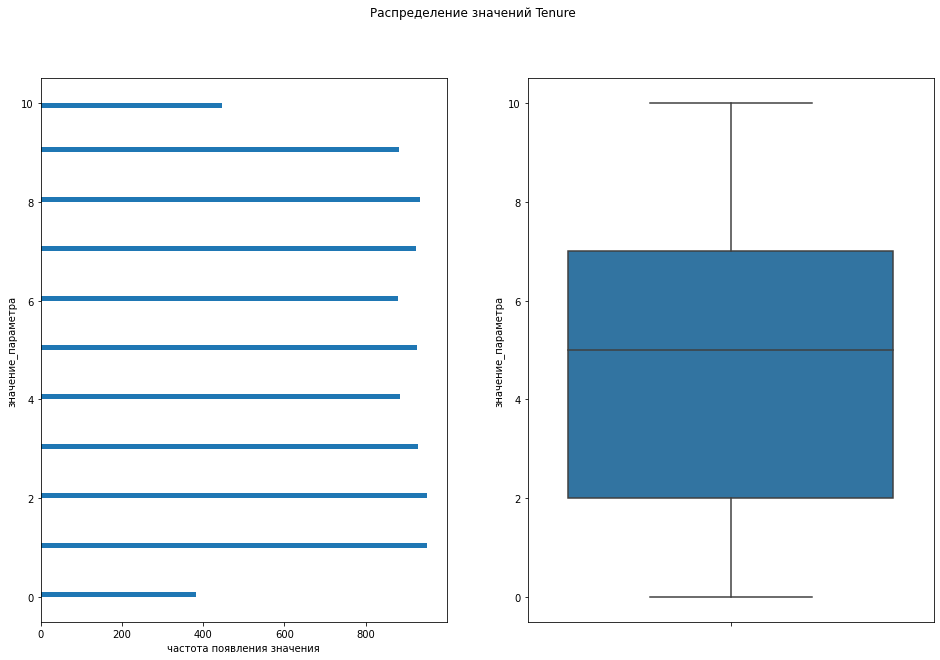

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
fig.suptitle("Распределение значений Tenure")
y = df_raw["Tenure"]
ax[0].set_xlabel("частота появления значения")
ax[0].set_ylabel("значение_параметра")
ax[1].set_ylabel("значение_параметра")
ax[0].hist(y, orientation="horizontal", bins=100)
sns.boxplot(data=y, orient="v", ax=ax[1])
ax[1].set_xticklabels([])
plt.show()

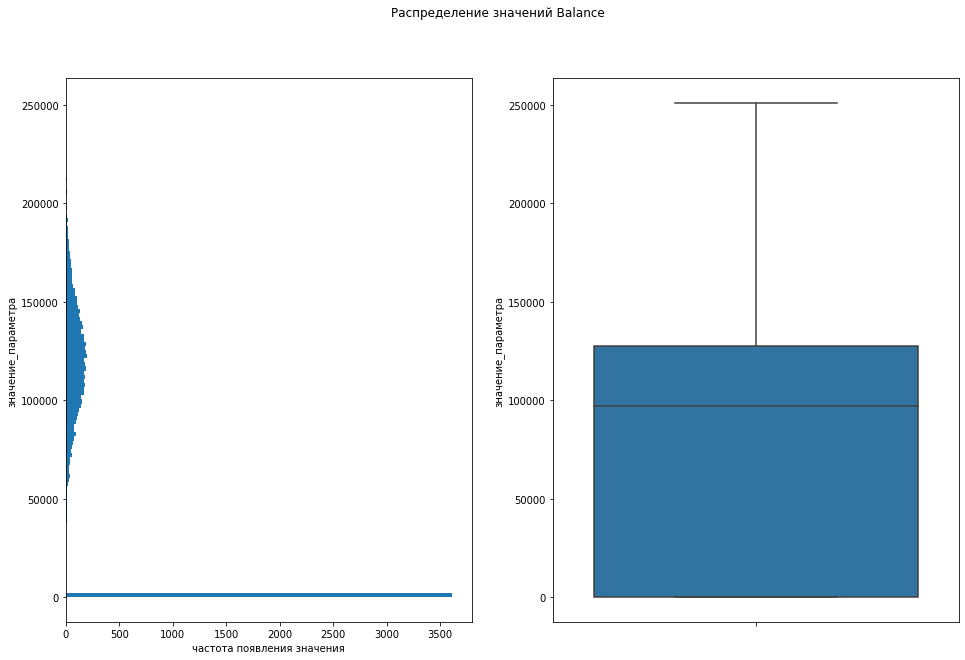

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
fig.suptitle("Распределение значений Balance")
y = df_raw["Balance"]
ax[0].set_xlabel("частота появления значения")
ax[0].set_ylabel("значение_параметра")
ax[1].set_ylabel("значение_параметра")
ax[0].hist(y, orientation="horizontal", bins=120)
sns.boxplot(data=y, orient="v", ax=ax[1])
ax[1].set_xticklabels([])
plt.show()

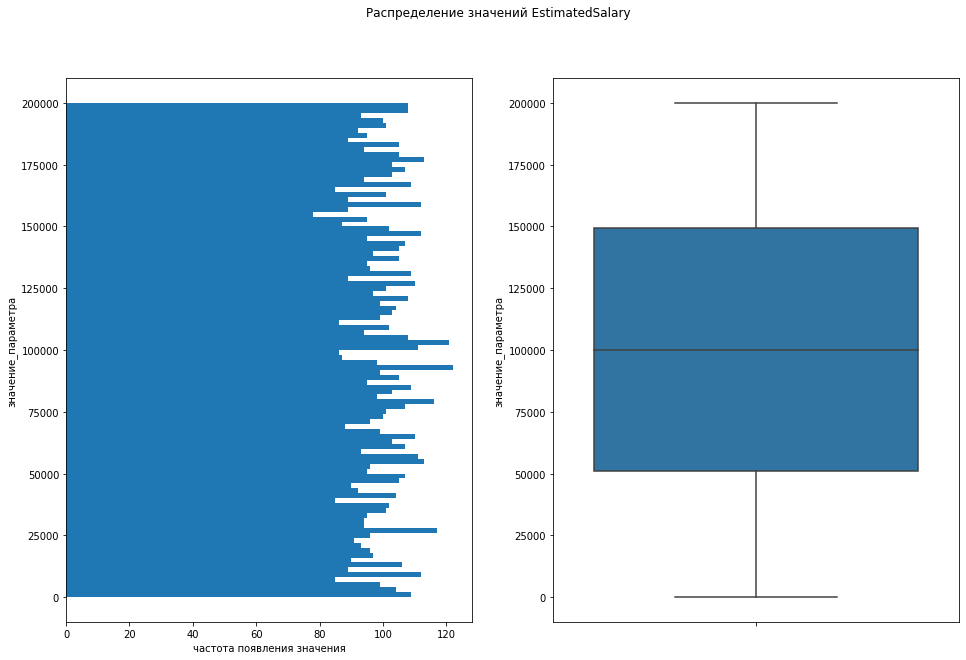

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
fig.suptitle("Распределение значений EstimatedSalary")
y = df_raw["EstimatedSalary"]
ax[0].set_xlabel("частота появления значения")
ax[0].set_ylabel("значение_параметра")
ax[1].set_ylabel("значение_параметра")
ax[0].hist(y, orientation="horizontal", bins=100)
sns.boxplot(data=y, orient="v", ax=ax[1])
ax[1].set_xticklabels([])
plt.show()

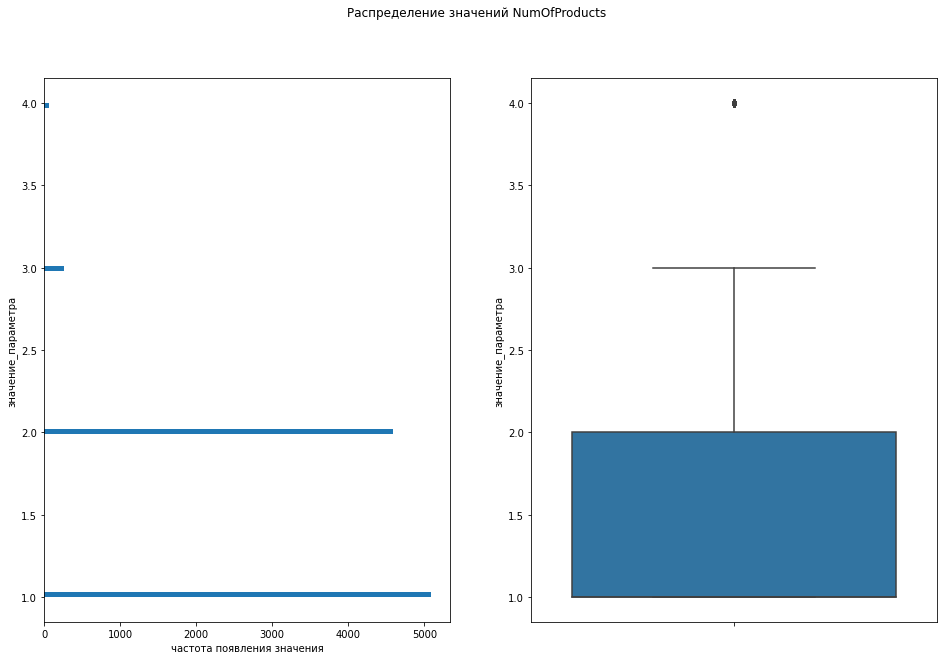

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
fig.suptitle("Распределение значений NumOfProducts")
y = df_raw["NumOfProducts"]
ax[0].set_xlabel("частота появления значения")
ax[0].set_ylabel("значение_параметра")
ax[1].set_ylabel("значение_параметра")
ax[0].hist(y, orientation="horizontal", bins=100)
sns.boxplot(data=y, orient="v", ax=ax[1])
ax[1].set_xticklabels([])
plt.show()

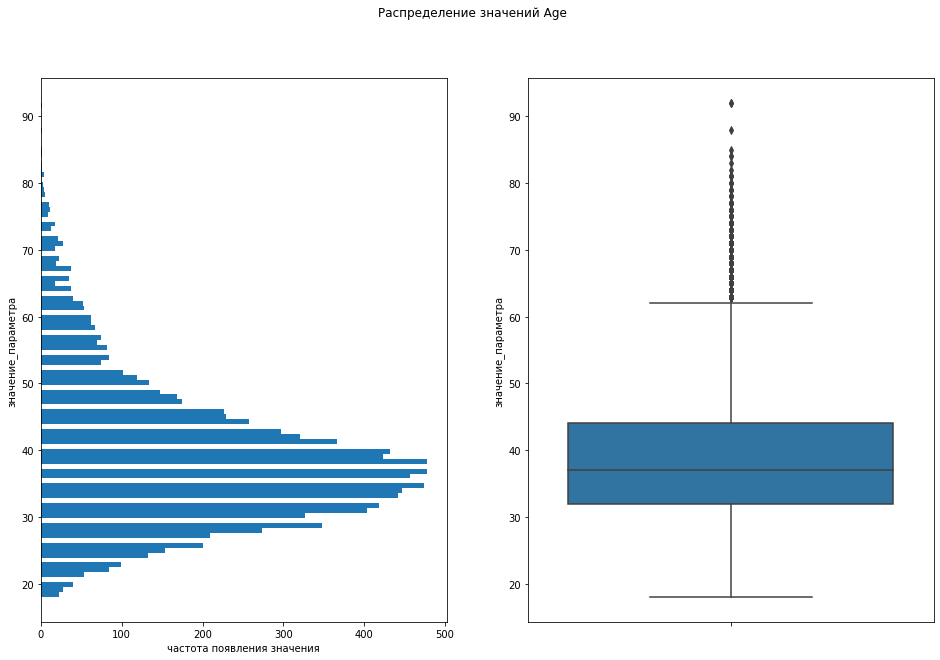

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
fig.suptitle("Распределение значений Age")
y = df_raw["Age"]
ax[0].set_xlabel("частота появления значения")
ax[0].set_ylabel("значение_параметра")
ax[1].set_ylabel("значение_параметра")
ax[0].hist(y, orientation="horizontal", bins=100)
sns.boxplot(data=y, orient="v", ax=ax[1])
ax[1].set_xticklabels([])
plt.show()

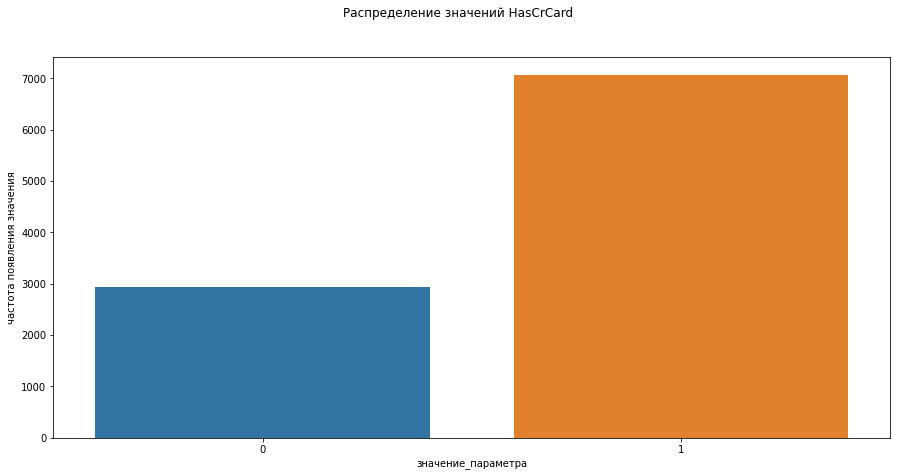

In [15]:
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Распределение значений HasCrCard")
y = df_raw["HasCrCard"].value_counts()
ax.set_ylabel("частота появления значения")
ax.set_xlabel("значение_параметра")
sns.barplot(x=y.index.values, y=y.values)

plt.show()

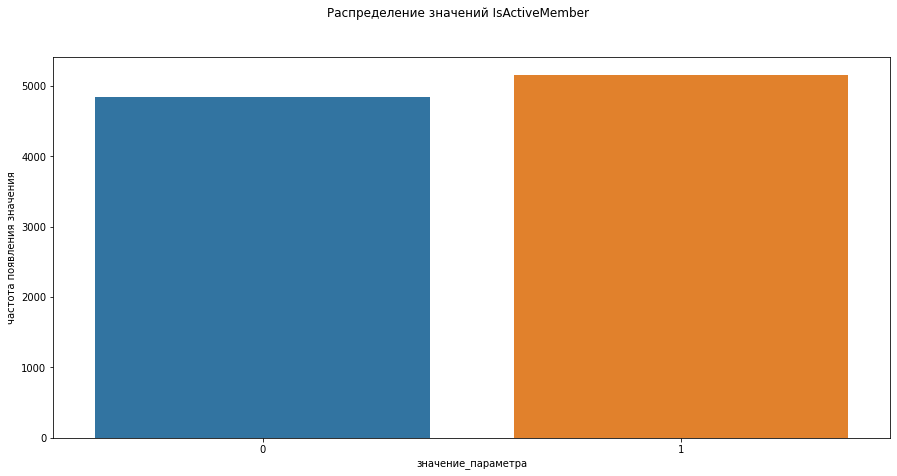

In [16]:
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Распределение значений IsActiveMember")
y = df_raw["IsActiveMember"].value_counts()
ax.set_ylabel("частота появления значения")
ax.set_xlabel("значение_параметра")
sns.barplot(x=y.index.values, y=y.values)

plt.show()

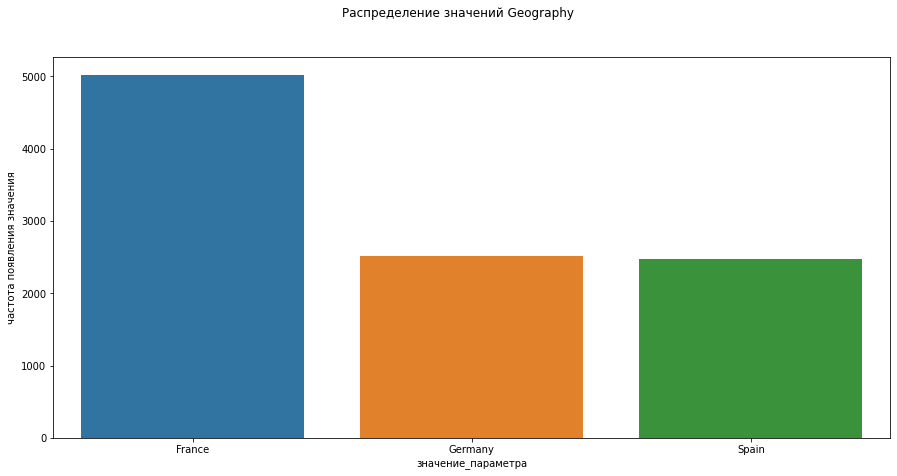

In [17]:
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Распределение значений Geography")
y = df_raw["Geography"].value_counts()
ax.set_ylabel("частота появления значения")
ax.set_xlabel("значение_параметра")
sns.barplot(x=y.index.values, y=y.values)
plt.show()

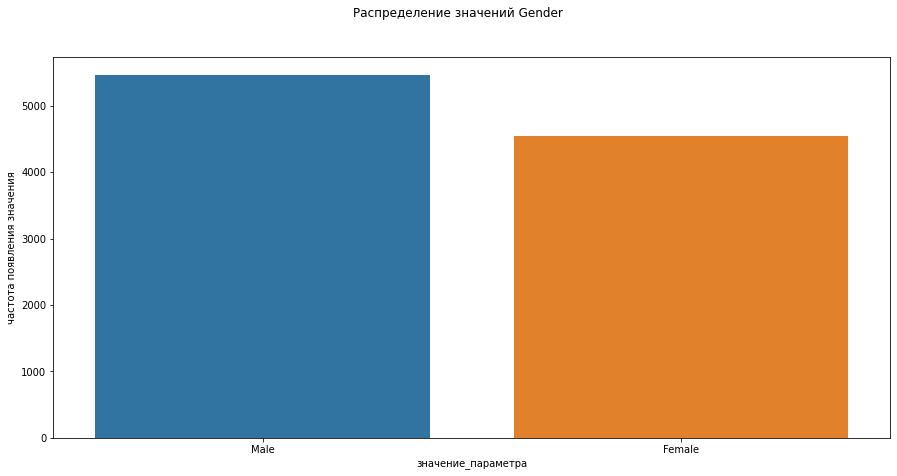

In [18]:
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Распределение значений Gender")
y = df_raw["Gender"].value_counts()
ax.set_ylabel("частота появления значения")
ax.set_xlabel("значение_параметра")
sns.barplot(x=y.index.values, y=y.values)
plt.show()

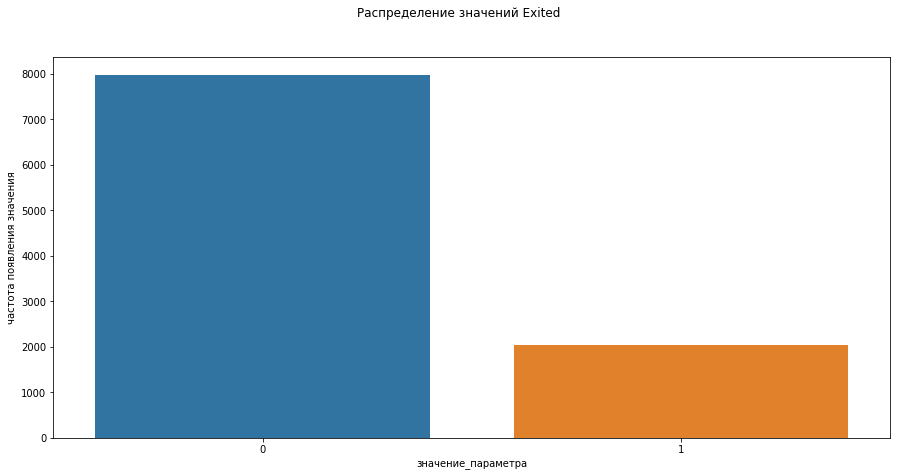

In [19]:
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Распределение значений Exited")
y = df_raw["Exited"].value_counts()
ax.set_ylabel("частота появления значения")
ax.set_xlabel("значение_параметра")
sns.barplot(x=y.index.values, y=y.values)
plt.show()

Проблемы в числовых данных не обнаружены.

Количество ушедших клиентов в таблице примерно в 4 раза меньше количества оставшихся. Стоит учесть этот дисбаланс при обучении моделей.

Проверим, есть ли повторяющиеся значения в столбце `customerid`:

In [20]:
df["CustomerId"].duplicated().sum()

0

Повторяющихся значений нет, так что можно удалить данный столбец.

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

***Вывод***

У нас в распоряжении одна таблица, в которой имеются данные по клиентам банка.
Каждый объект в наборе данных — это информация о характеристиках одного клиента и его решении об уходе. 

## Подготовка данных к обучению

### Проверка явных дубликатов

In [21]:
df.duplicated().sum()

0

Явные дубликаты не обнаружены.

### Очистка неиспользуемых данных

Удалим ненужные столбцы:

In [22]:
del df["RowNumber"]
del df["Surname"]
del df["CustomerId"]

### One-Hot Encoding

Используем технику прямого кодирования, или отображения (One-Hot Encoding, OHE), чтобы преобразовать категориальные признаки в численные:

In [23]:
df = pd.get_dummies(df, drop_first=True)

In [24]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0000,0.0000,1,1,1,"101,348.8800",1,0,0,0
1,608,41,1.0000,"83,807.8600",1,0,1,"112,542.5800",0,0,1,0
2,502,42,8.0000,"159,660.8000",3,1,0,"113,931.5700",1,0,0,0
3,699,39,1.0000,0.0000,2,0,0,"93,826.6300",0,0,0,0
4,850,43,2.0000,"125,510.8200",1,1,1,"79,084.1000",0,0,1,0


### Стиль заголовков

Приведем названия колонок к нижнему регистру:

In [25]:
df.columns = df.columns.str.lower()  # изменение столбцов
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   creditscore        10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             9091 non-null   float64
 3   balance            10000 non-null  float64
 4   numofproducts      10000 non-null  int64  
 5   hascrcard          10000 non-null  int64  
 6   isactivemember     10000 non-null  int64  
 7   estimatedsalary    10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_germany  10000 non-null  uint8  
 10  geography_spain    10000 non-null  uint8  
 11  gender_male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


### Работа с пропусками

Посмотрим, есть ли пропуски в данных:

In [26]:
df.isna().sum()

creditscore            0
age                    0
tenure               909
balance                0
numofproducts          0
hascrcard              0
isactivemember         0
estimatedsalary        0
exited                 0
geography_germany      0
geography_spain        0
gender_male            0
dtype: int64

В столбце `tenure` есть пропуски. 

Посмотрим, есть ли закономерность в распределении строк с пропусками в базе данных:

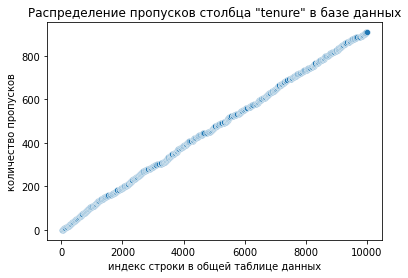

In [27]:
sns.scatterplot(
    x=df[df.loc[:, "tenure"].isna()].index.tolist(),
    y=range(len(df[df["tenure"].isna()])),
)
plt.xlabel("индекс строки в общей таблице данных")
plt.ylabel("количество пропусков")
plt.title('Распределение пропусков столбца "tenure" в базе данных')
plt.show()

Пропуски распределены случайным образом.

Проверим визуально эти строки:

In [28]:
df[df.loc[:, "tenure"].isna()].head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_germany,geography_spain,gender_male
30,591,39,NaN,0.0000,3,1,0,"140,469.3800",1,0,1,0
48,550,38,NaN,"103,391.3800",1,0,1,"90,878.1300",0,1,0,1
51,585,36,NaN,"146,050.9700",2,0,0,"86,424.5700",0,1,0,1
53,655,41,NaN,"125,561.9700",1,0,0,"164,040.9400",1,1,0,1
60,742,35,NaN,"136,857.0000",1,0,0,"84,509.5700",0,1,0,1


Визуально по таблице не видно никаких закономерностей с другими строками.

Взглянем шире, проверим распределения остальных столбцов для данных с пропусками и без:

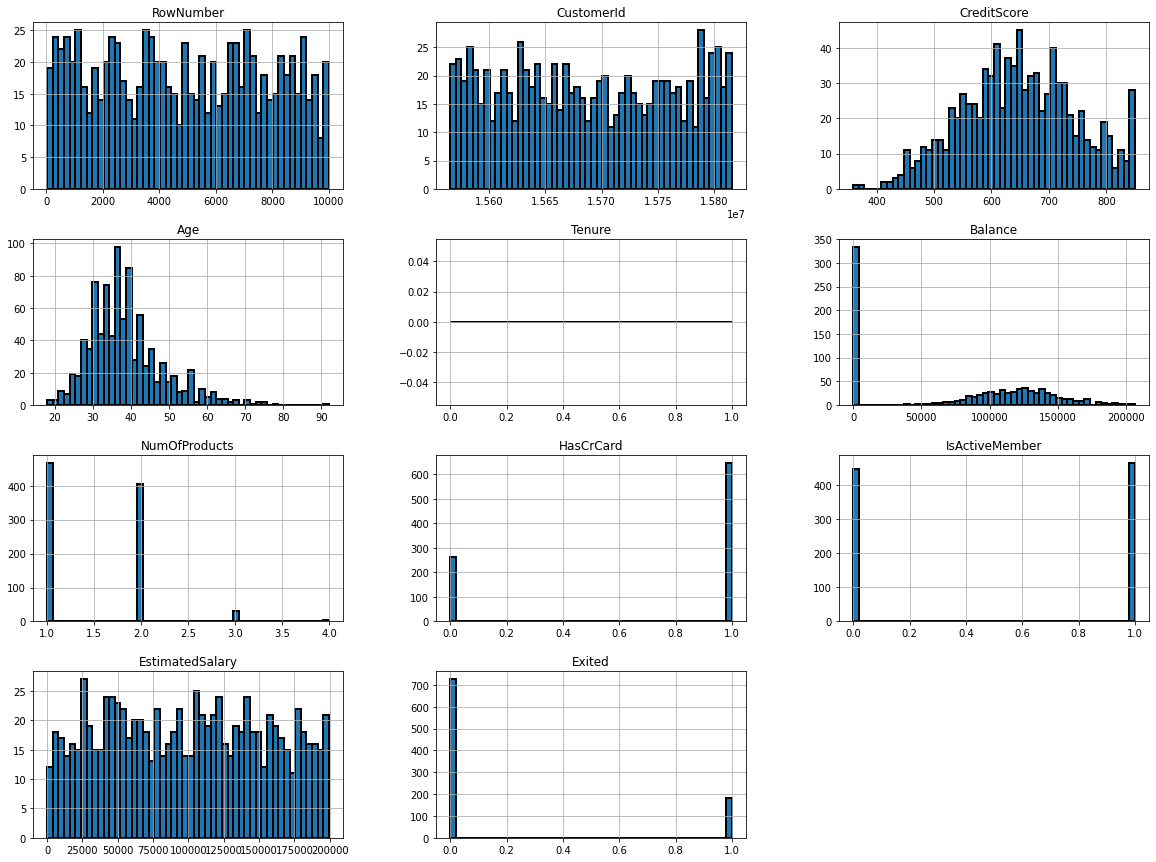

In [29]:
df_raw[df_raw.loc[:, "Tenure"].isna()].hist(
    bins=50, figsize=(20, 15), edgecolor="black", linewidth=2
)
plt.show()

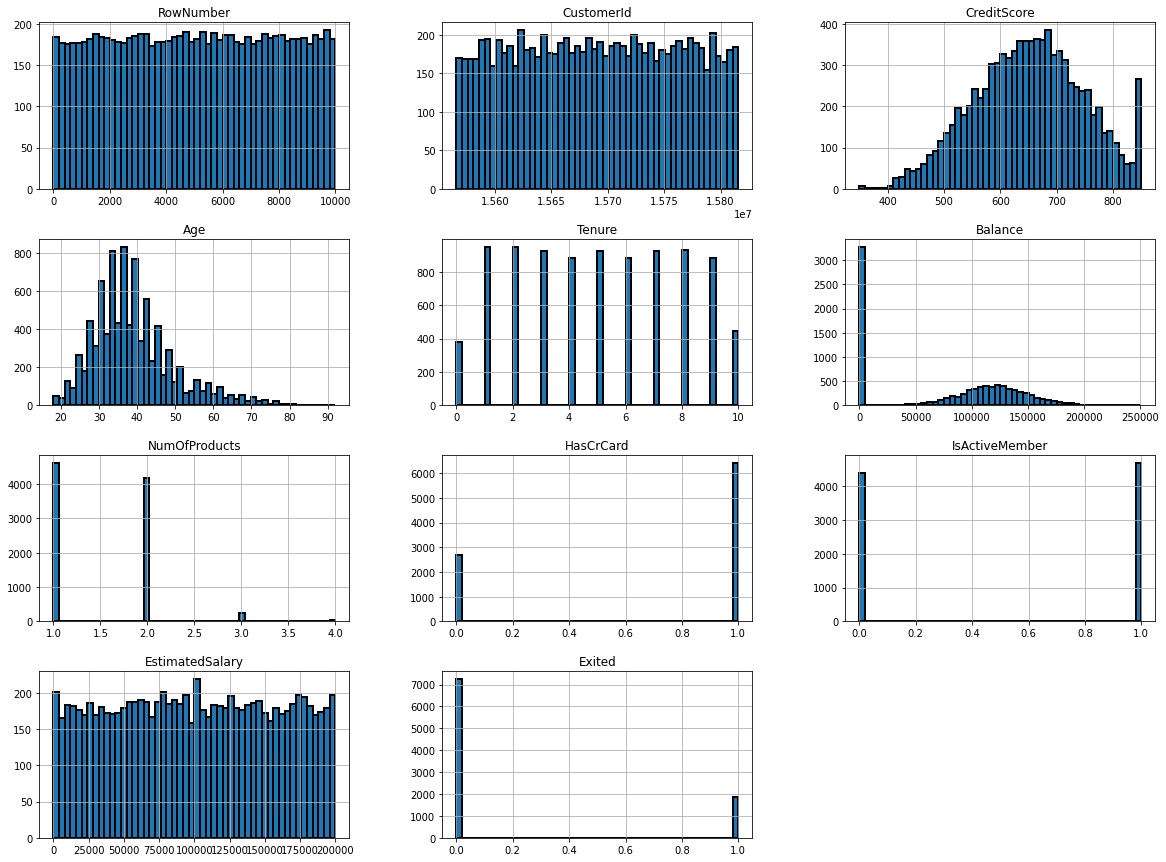

In [30]:
df_raw[df_raw.loc[:, "Tenure"].notna()].hist(
    bins=50, figsize=(20, 15), edgecolor="black", linewidth=2
)
plt.show()

Отличий визуально не видно.

In [31]:
df_raw[df_raw.loc[:, "Tenure"].isna()]["NumOfProducts"].value_counts(normalize=True)

1   0.5138
2   0.4466
3   0.0352
4   0.0044
Name: NumOfProducts, dtype: float64

In [32]:
df_raw[df_raw.loc[:, "Tenure"].notna()]["NumOfProducts"].value_counts(normalize=True)

1   0.5079
2   0.4602
3   0.0257
4   0.0062
Name: NumOfProducts, dtype: float64

Соотношение количества продуктов у клиентов с пропусками примерно соотвествует клиентам без пропуска, а значит нам подойдет для заполнения среднее или медианное значение по столбцу (значения распределены нормально)

In [33]:
df["tenure"].isna().mean()

0.0909

Имеем 9% пропусков в столбце `tenure`. Относительно немного.

Заполним пропуски средним значением:

In [34]:
df["tenure"] = df["tenure"].fillna(df["tenure"].mean())

In [35]:
# А еще можно предсказать tenure c помощью LinearSVC

# X_train = df[df['tenure'].notna()].drop(['tenure'], axis=1)
# y_train = df[df['tenure'].notna()]['tenure']
# X_test = df[df['tenure'].isna()].drop(['tenure'], axis=1)

# model = LinearSVC(random_state=12345)
# model.fit(X_train, y_train)
# model.predict(X_test)
# preds = model.predict(X_test)
# t = pd.DataFrame(preds, index=X_test.index)
# df.loc[df['tenure'].isna(),'tenure'] = t.values

### Изменение типа данных


`tenure` можно привести к целочисленному типу:

In [36]:
df["tenure"] = df["tenure"].astype(np.int32)

Чтобы ускорить работу моделей, уменьшим битность для остальных числовых данных: 

In [37]:
int64 = df.select_dtypes(include=["int64"]).columns.tolist()
for x in int64:
    df[x] = df[x].astype(np.int32)

In [38]:
float64 = df.select_dtypes(include=["float64"]).columns.tolist()
for x in float64:
    df[x] = df[x].astype(np.float32)

In [39]:
df.dtypes

creditscore            int32
age                    int32
tenure                 int32
balance              float32
numofproducts          int32
hascrcard              int32
isactivemember         int32
estimatedsalary      float32
exited                 int32
geography_germany      uint8
geography_spain        uint8
gender_male            uint8
dtype: object

**Вывод:**

Чтобы ускорить работу с таблицей, мы уменьшили битность для числовых данных. Заполнили пропуски в таблице. Удалили лишние для модели данные. Использовали метод One-Hot Encoding, чтобы преобразовать категориальные признаки в численные.

## Разбиваем данные на выборки

Каких-то строгих правил в разбиении данных на выборки не существует.

Разделим иходные данные на 2 выборки с пропорциями:


    Обучающая - 80%
    Тестовая - 20%
    

Добавим стратификацию, для того того, чтобы уменьшить разницу точности оценок между выборками при прогнозировании моделью:

In [40]:
features = df.drop(["exited"], axis=1)
target = df["exited"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, train_size=0.8, stratify=target, random_state=12345
)  # на тренировочные данные 80%
# X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test, test_size=0.5, stratify=target_rem, random_state=12345) # делим оставшееся на 2 : валид и тест

Сделаем стандартизацию данных и сохраним в отдельные переменные. Для этого отберем признаки, которые будем стандартизировать.

`tenure` и `numofproducts` дискретные переменные. Поэтому их не будем трогать.

In [41]:
features_for_scaling = []
for x in features.columns:
    if (
        features[x].value_counts().count() != 2
        and x != "tenure"
        and x != "numofproducts"
    ):
        features_for_scaling.append(x)

In [42]:
X_train_s = X_train.copy()
X_test_s = X_test.copy()
scaler = StandardScaler()
scaler.fit(X_train_s[features_for_scaling])
X_train_s[features_for_scaling] = scaler.transform(X_train_s[features_for_scaling])
X_test_s[features_for_scaling] = scaler.transform(X_test_s[features_for_scaling])

## Обучаем модели

### Простое обучение

Вначале обучим модели без учёта дисбаланса классов c параметрами по умолчанию.

Объявим переменные:

In [43]:
rstate = 12345
algorithms = [
    RandomForestClassifier(random_state=rstate), 
    lgb(random_state=rstate), 
    CatBoostClassifier( silent=True, random_state=rstate),
    LogisticRegression(),
]  # применяемые модели
algorithms_names = [
    "RandomForest",
    "LGBMClassifier",
    "CatBoostClassifier",
    "LogisticRegression",
]  # названия моделей
folds = 5  # количество выборок при к-в
trials = 7  # количество итераций для оптимизации
models = []  # сюда будем складывать модели
sampler = TPESampler(
    seed=10
)  # фиксируем псевдослучайность для оптимизатора чтобы получить воспроизводимый эксперимент.

Создадим таблицу, куда будем сохранять наши результаты:

In [44]:
df_report = pd.DataFrame(columns={"model"}, data=[0])

In [45]:
df_report["model"] = "RandomForest"
df_report = df_report.set_index("model")

Обучим три модели (RandomForestClassifier, LGBMClassifier, CatBoostClassifier) на тренировочных, нестандартизированных данных и занесем результаты в отчет:

In [46]:
for n in range(len(algorithms)):
    model = deepcopy(algorithms[n])
    model.fit(X_train, y_train)
    df_report.loc[algorithms_names[n], "f1"] = f1_score(y_test, model.predict(X_test))
    df_report.loc[algorithms_names[n], "roc_auc"] = roc_auc_score(
        y_test, model.predict_proba(X_test)[:, 1]
    )
    df_report.loc[algorithms_names[n], "accuracy"] = model.score(X_test, y_test)
    models.append(model)

In [47]:
df_report

,f1,roc_auc,accuracy
model,,,
RandomForest,0.5776,0.8606,0.8625
LGBMClassifier,0.6088,0.8675,0.8670
CatBoostClassifier,0.6070,0.8707,0.8660
LogisticRegression,0.0688,0.6815,0.7835


Посмотрим на результаты. Оценивать модели будем по F1 мере - она является неплохой метрикой при дисбалансе классов. 

LGBMClassifier показывает лучший результат. Худший результат у логистической регресии. Это связано с тем, что LogisticRegression - более простая модель, по сравнению с остальными.

Посмотрим, сможем ли мы улучшить эти показатели используя оптимизацию, учитывая дисбаланс классов, изменяя порог и обучаясь на стандартизированных данных.

### Оптимизируем модели

Создадим функцию, где укажем какие параметры будем оптимизировать через библиотеку Optuna и зададим f1 как целевой показатель. Оптимизировать модель мы будем по 6 гиперпараметрам, включая параметр изменения весов класса. И все это способом кросс-валидации:

In [48]:
# целевая функция
def objective(trial, X, y):
    param_grid = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "class_weight": trial.suggest_categorical(
            "class_weight", ["balanced", "balanced_subsample", None]
        ),
        "n_estimators": trial.suggest_int("n_estimators", 1, 101, step=1),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 31, step=1),
        "max_depth": trial.suggest_int("max_depth", 1, 11, step=1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 41, step=1),
    }

    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rstate)

    cv_predicts = []

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model = RandomForestClassifier(random_state=rstate, **param_grid)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        cv_predicts.append(f1_score(y_test, preds))

    return np.mean(cv_predicts)

Подадим функцию в оптимизатор и получим наилучшие параметры модели путем нахождения наибольшего показателя f1 на тренировочной выборке.

In [49]:
study = optuna.create_study(
    direction="maximize", study_name="forest", sampler=sampler
)  # устанавливаем задачу получения максимального значения от созданной функции.
func = lambda trial: objective(
    trial, X_train, y_train
)  # закидываем на вход фичи и таргет
# n_trials - кол-во итераций
study.optimize(
    func, n_trials=15, show_progress_bar=True
)  # запускаем оптимизатор. увеличил количество итераций чтобы было больше моделей без учета дисбаланса

[I 2022-07-25 05:42:08,639] A new study created in memory with name: forest
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2022-07-25 05:42:11,010] Trial 0 finished with value: 0.6081787447716682 and parameters: {'criterion': 'gini', 'class_weight': 'balanced_subsample', 'n_estimators': 23, 'min_samples_leaf': 7, 'max_depth': 9, 'min_samples_split': 8}. Best is trial 0 with value: 0.6081787447716682.
[I 2022-07-25 05:42:17,589] Trial 1 finished with value: 0.5984192071679473 and parameters: {'criterion': 'entropy', 'class_weight': 'balanced', 'n_estimators': 83, 'min_samples_leaf': 19, 'max_depth': 8, 'min_samples_split': 13}. Best is trial 0 with value: 0.6081787447716682.
[I 2022-07-25 05:42:20,478] Trial 2 finished with value: 0.5833231288291565 and parameters: {'criterion': 'gini', 'class_weight': 'balanced', 'n_estimators': 69, 'min_samples_leaf': 14, 'max_depth': 5, 'min_samples_split': 26}. Best is trial 0 with value: 0.6081787447716682.
[I 2022-07-25 05:42:24,066] Trial 3 finished with value: 0.5034964015345887 and parameters: {'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'n_est

Выводим лучшие параметры модели:

In [50]:
print(f"Лучший показатель f1 на тренировочной выборке: {study.best_value:.5f}")
print("")
print(f"Лучшие параметры:")

for key, value in study.best_params.items():
    print(f"{key}: {value}")

Лучший показатель f1 на тренировочной выборке: 0.61596

Лучшие параметры:
criterion: entropy
class_weight: balanced_subsample
n_estimators: 83
min_samples_leaf: 7
max_depth: 10
min_samples_split: 16


Посмотрим важность гиперпараметров на результаты:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.


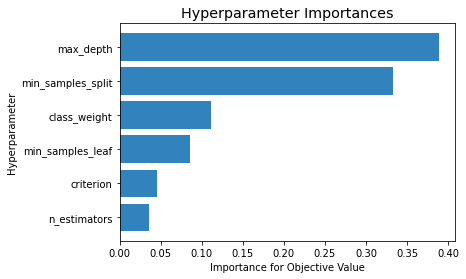

In [51]:
plot_param_importances(study)

Заметно, что изменение параметра критерия менее влияло на результат. И самый важный гиперпараметр - максимальная глубина.

Загружаем лучшие параметры в модель. Сохраняем её. 

In [52]:
model = RandomForestClassifier(random_state=rstate, **study.best_params)
model.fit(X_train, y_train)
models.append(model)

In [53]:
df_report.loc["RandomForest_opt", "f1"] = f1_score(y_test, model.predict(X_test))
df_report.loc["RandomForest_opt", "roc_auc"] = roc_auc_score(
    y_test, model.predict_proba(X_test)[:, 1]
)
df_report.loc["RandomForest_opt", "accuracy"] = model.score(X_test, y_test)

Теперь обучим модель на масштабируемых данных:

In [54]:
study = optuna.create_study(
    direction="maximize", study_name="forest_s", sampler=sampler
)  # устанавливаем задачу получения максимального значения от созданной функции.
func = lambda trial: objective(
    trial, X_train_s, y_train
)  # закидываем на вход фичи и таргет
# n_trials - кол-во итераций
study.optimize(func, n_trials=trials, show_progress_bar=False)  # запускаем оптимизатор

[I 2022-07-25 05:42:46,574] A new study created in memory with name: forest_s
[I 2022-07-25 05:42:48,252] Trial 0 finished with value: 0.5778068699320182 and parameters: {'criterion': 'gini', 'class_weight': 'balanced_subsample', 'n_estimators': 50, 'min_samples_leaf': 31, 'max_depth': 5, 'min_samples_split': 14}. Best is trial 0 with value: 0.5778068699320182.
[I 2022-07-25 05:42:51,197] Trial 1 finished with value: 0.5963176128513337 and parameters: {'criterion': 'entropy', 'class_weight': 'balanced', 'n_estimators': 79, 'min_samples_leaf': 23, 'max_depth': 7, 'min_samples_split': 3}. Best is trial 1 with value: 0.5963176128513337.
[I 2022-07-25 05:42:51,712] Trial 2 finished with value: 0.4096866460623567 and parameters: {'criterion': 'entropy', 'class_weight': None, 'n_estimators': 17, 'min_samples_leaf': 2, 'max_depth': 4, 'min_samples_split': 6}. Best is trial 1 with value: 0.5963176128513337.
[I 2022-07-25 05:42:52,130] Trial 3 finished with value: 0.4849834215511259 and paramet

In [55]:
print(f"Лучший показатель f1 на тренировочной выборке: {study.best_value:.5f}")
print("")
print(f"Лучшие параметры:")

for key, value in study.best_params.items():
    print(f"{key}: {value}")

Лучший показатель f1 на тренировочной выборке: 0.59632

Лучшие параметры:
criterion: entropy
class_weight: balanced
n_estimators: 79
min_samples_leaf: 23
max_depth: 7
min_samples_split: 3


Загружаем лучшие параметры в модель. Сохраняем её. 

In [56]:
model = RandomForestClassifier(random_state=rstate, **study.best_params)
model.fit(X_train_s, y_train)
models.append(model)

In [57]:
df_report.loc["RandomForest_opt_scaled", "f1"] = f1_score(
    y_test, model.predict(X_test_s)
)
df_report.loc["RandomForest_opt_scaled", "roc_auc"] = roc_auc_score(
    y_test, model.predict_proba(X_test_s)[:, 1]
)
df_report.loc["RandomForest_opt_scaled", "accuracy"] = model.score(X_test_s, y_test)

Проводим те же действия на LGBMClassifier:

In [58]:
def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", None]),
    }

    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rstate)

    cv_predicts = []
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_trainCV, X_testCV = X.iloc[train_idx], X.iloc[test_idx]
        y_trainCV, y_testCV = y.iloc[train_idx], y.iloc[test_idx]

        model = lgb(**param_grid)
        model.fit(X_trainCV, y_trainCV)
        preds = model.predict(X_testCV)
        cv_predicts.append(f1_score(y_testCV, preds))

    return np.mean(cv_predicts)

In [59]:
study = optuna.create_study(direction="maximize", study_name="LGB", sampler=sampler)
func = lambda trial: objective(trial, X_train, y_train)
# n_trials - кол-во итераций
study.optimize(func, n_trials=trials, show_progress_bar=True)

[I 2022-07-25 05:42:56,648] A new study created in memory with name: LGB
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/7 [00:00<?, ?it/s]

[I 2022-07-25 05:43:01,953] Trial 0 finished with value: 0.5752633724830007 and parameters: {'n_estimators': 821, 'learning_rate': 0.03613095307008717, 'num_leaves': 244, 'max_depth': 7, 'min_child_samples': 120, 'class_weight': None}. Best is trial 0 with value: 0.5752633724830007.
[I 2022-07-25 05:43:03,829] Trial 1 finished with value: 0.591240636509973 and parameters: {'n_estimators': 303, 'learning_rate': 0.020891726023086532, 'num_leaves': 28, 'max_depth': 6, 'min_child_samples': 150, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.591240636509973.
[I 2022-07-25 05:43:05,073] Trial 2 finished with value: 0.5654155233256457 and parameters: {'n_estimators': 176, 'learning_rate': 0.25309578300407093, 'num_leaves': 188, 'max_depth': 9, 'min_child_samples': 171, 'class_weight': None}. Best is trial 1 with value: 0.591240636509973.
[I 2022-07-25 05:43:07,805] Trial 3 finished with value: 0.595832616366782 and parameters: {'n_estimators': 620, 'learning_rate': 0.0161379054399

In [60]:
print(f"Лучший показатель f1 на тренировочной выборке: {study.best_value:.5f}")
print("")
print(f"Лучшие параметры:")

for key, value in study.best_params.items():
    print(f"{key}: {value}")
    best_tresh = value

Лучший показатель f1 на тренировочной выборке: 0.59583

Лучшие параметры:
n_estimators: 620
learning_rate: 0.016137905439924945
num_leaves: 230
max_depth: 4
min_child_samples: 94
class_weight: balanced


In [61]:
model = lgb(random_state=rstate, **study.best_params)
model.fit(X_train, y_train)
models.append(model)

In [62]:
df_report.loc["LGBMClassifier_opt", "f1"] = f1_score(y_test, model.predict(X_test))
df_report.loc["LGBMClassifier_opt", "roc_auc"] = roc_auc_score(
    y_test, model.predict_proba(X_test)[:, 1]
)
df_report.loc["LGBMClassifier_opt", "accuracy"] = model.score(X_test, y_test)

Теперь на масшабируемых данных:

In [63]:
study = optuna.create_study(
    direction="maximize", study_name="LGB_scaled", sampler=sampler
)
func = lambda trial: objective(trial, X_train_s, y_train)
# n_trials - кол-во итераций
study.optimize(func, n_trials=trials, show_progress_bar=True)

[I 2022-07-25 05:43:17,029] A new study created in memory with name: LGB_scaled
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/7 [00:00<?, ?it/s]

[I 2022-07-25 05:43:19,016] Trial 0 finished with value: 0.5734868193862201 and parameters: {'n_estimators': 399, 'learning_rate': 0.26069896620256644, 'num_leaves': 127, 'max_depth': 5, 'min_child_samples': 167, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5734868193862201.
[I 2022-07-25 05:43:25,065] Trial 1 finished with value: 0.5789433302817228 and parameters: {'n_estimators': 648, 'learning_rate': 0.07182410395980794, 'num_leaves': 271, 'max_depth': 10, 'min_child_samples': 67, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5789433302817228.
[I 2022-07-25 05:43:25,322] Trial 2 finished with value: 0.5473950060103976 and parameters: {'n_estimators': 35, 'learning_rate': 0.024266595754381302, 'num_leaves': 71, 'max_depth': 3, 'min_child_samples': 55, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5789433302817228.
[I 2022-07-25 05:43:25,884] Trial 3 finished with value: 0.5877632215179034 and parameters: {'n_estimators': 139, 'learning_rate': 0

In [64]:
print(f"Лучший показатель f1 на тренировочной выборке: {study.best_value:.5f}")
print("")
print(f"Лучшие параметры:")

for key, value in study.best_params.items():
    print(f"{key}: {value}")
    best_tresh = value

Лучший показатель f1 на тренировочной выборке: 0.58776

Лучшие параметры:
n_estimators: 139
learning_rate: 0.2448685829660518
num_leaves: 133
max_depth: 3
min_child_samples: 172
class_weight: None


In [65]:
model = lgb(random_state=rstate, **study.best_params)
model.fit(X_train_s, y_train)
models.append(model)

In [66]:
df_report.loc["LGBMClassifier_opt_scaled", "f1"] = f1_score(
    y_test, model.predict(X_test_s)
)
df_report.loc["LGBMClassifier_opt_scaled", "roc_auc"] = roc_auc_score(
    y_test, model.predict_proba(X_test_s)[:, 1]
)
df_report.loc["LGBMClassifier_opt_scaled", "accuracy"] = model.score(X_test_s, y_test)

Найдем наилучшую модель CatBoostClassifier изменяя только гиперпараметр веса классов:

In [67]:
best_model_params = None
result = 0
for w in [None, "Balanced", "SqrtBalanced"]:
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rstate)
    cv_predicts = []

    for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
        X_trainCV, X_testCV = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_trainCV, y_testCV = y_train.iloc[train_idx], y_train.iloc[test_idx]
        model = CatBoostClassifier(auto_class_weights=w, random_state=rstate, silent=True)
        model.fit(X_trainCV, y_trainCV)
        preds = model.predict(X_testCV)
        cv_predicts.append(f1_score(y_testCV, preds))

    if np.mean(cv_predicts) > result:
        result = np.mean(cv_predicts)
        best_model_params = w

In [68]:
model = CatBoostClassifier(auto_class_weights=best_model_params, random_state=rstate, silent=True)
model.fit(X_train, y_train)

In [69]:
df_report.loc["CatBoostClassifier_opt", "f1"] = f1_score(
    y_test, model.predict(X_test)
)
df_report.loc["CatBoostClassifier_opt", "roc_auc"] = roc_auc_score(
    y_test, model.predict_proba(X_test)[:, 1]
)
df_report.loc["CatBoostClassifier_opt", "accuracy"] = model.score(X_test, y_test)
models.append(model)

In [70]:
model.get_params()

{'auto_class_weights': 'SqrtBalanced', 'random_state': 12345, 'silent': True}

Теперь на масшабируемых данных:

In [71]:
best_model_params = None
result = 0
for w in [None, "Balanced", "SqrtBalanced"]:
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rstate)
    cv_predicts = []

    for idx, (train_idx, test_idx) in enumerate(cv.split(X_train_s, y_train)):
        X_trainCV, X_testCV = X_train_s.iloc[train_idx], X_train_s.iloc[test_idx]
        y_trainCV, y_testCV = y_train.iloc[train_idx], y_train.iloc[test_idx]
        model = CatBoostClassifier(auto_class_weights=w, random_state=rstate, silent=True)
        model.fit(X_trainCV, y_trainCV)
        preds = model.predict(X_testCV)
        cv_predicts.append(f1_score(y_testCV, preds))

    if np.mean(cv_predicts) > result:
        result = np.mean(cv_predicts)
        best_model_params = w

In [72]:
model = CatBoostClassifier(auto_class_weights=best_model_params, random_state=rstate, silent=True)
model.fit(X_train_s, y_train)

In [73]:
df_report.loc["CatBoostClassifier_opt_scaled", "f1"] = f1_score(
    y_test, model.predict(X_test_s)
)
df_report.loc["CatBoostClassifier_opt_scaled", "roc_auc"] = roc_auc_score(
    y_test, model.predict_proba(X_test_s)[:, 1]
)
df_report.loc["CatBoostClassifier_opt_scaled", "accuracy"] = model.score(
    X_test_s, y_test
)
models.append(model)

In [74]:
model.get_params()

{'auto_class_weights': 'SqrtBalanced', 'random_state': 12345, 'silent': True}

Прооптимизируем модель логистической регрессии:

In [75]:
def objective(trial, X, y):
    param_grid = {
        "penalty": trial.suggest_categorical("penalty", ["l2", "none"]),
        "max_iter": trial.suggest_int("max_iter", 70, 1501, step=1),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", None]),
    }

    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rstate)

    cv_predicts = []
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_trainCV, X_testCV = X.iloc[train_idx], X.iloc[test_idx]
        y_trainCV, y_testCV = y.iloc[train_idx], y.iloc[test_idx]

        model = LogisticRegression(**param_grid)

        model.fit(X_trainCV, y_trainCV)
        preds = model.predict(X_testCV)
        cv_predicts.append(f1_score(y_testCV, preds))

    return np.mean(cv_predicts)

In [76]:
sampler = TPESampler(seed=10)
study = optuna.create_study(direction="maximize", study_name="log_reg", sampler=sampler)
func = lambda trial: objective(trial, X_train, y_train)
# n_trials - кол-во итераций
study.optimize(func, n_trials=trials, show_progress_bar=False)

[I 2022-07-25 05:45:19,373] A new study created in memory with name: log_reg
[I 2022-07-25 05:45:19,855] Trial 0 finished with value: 0.4374704308309 and parameters: {'penalty': 'l2', 'max_iter': 977, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.4374704308309.
[I 2022-07-25 05:45:20,378] Trial 1 finished with value: 0.4374704308309 and parameters: {'penalty': 'l2', 'max_iter': 1159, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.4374704308309.
[I 2022-07-25 05:45:20,814] Trial 2 finished with value: 0.10435440968672113 and parameters: {'penalty': 'none', 'max_iter': 75, 'class_weight': None}. Best is trial 0 with value: 0.4374704308309.
[I 2022-07-25 05:45:21,289] Trial 3 finished with value: 0.4374704308309 and parameters: {'penalty': 'none', 'max_iter': 487, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.4374704308309.
[I 2022-07-25 05:45:21,770] Trial 4 finished with value: 0.4374704308309 and parameters: {'penalty': 'l2', 'max_iter': 604, 'clas

In [77]:
print(f"Лучший показатель accuracy на валидационной выборке: {study.best_value:.5f}")
print(f"Лучшие параметры:")
print("")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

Лучший показатель accuracy на валидационной выборке: 0.43747
Лучшие параметры:

penalty: l2
max_iter: 977
class_weight: balanced


In [78]:
model = LogisticRegression(random_state=rstate, **study.best_params)
model.fit(X_train, y_train)
df_report.loc["LogisticRegression_opt", "f1"] = f1_score(y_test, model.predict(X_test))
df_report.loc["LogisticRegression_opt", "roc_auc"] = roc_auc_score(
    y_test, model.predict_proba(X_test)[:, 1]
)
df_report.loc["LogisticRegression_opt", "accuracy"] = model.score(X_test, y_test)
models.append(model)

На масштабируемых данных:

In [79]:
sampler = TPESampler(seed=10)
study = optuna.create_study(
    direction="maximize", study_name="log_reg_scaled", sampler=sampler
)
func = lambda trial: objective(trial, X_train_s, y_train)
# n_trials - кол-во итераций
study.optimize(func, n_trials=trials, show_progress_bar=False)

[I 2022-07-25 05:45:22,929] A new study created in memory with name: log_reg_scaled
[I 2022-07-25 05:45:23,171] Trial 0 finished with value: 0.48551708382719205 and parameters: {'penalty': 'l2', 'max_iter': 977, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.48551708382719205.
[I 2022-07-25 05:45:23,454] Trial 1 finished with value: 0.48551708382719205 and parameters: {'penalty': 'l2', 'max_iter': 1159, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.48551708382719205.
[I 2022-07-25 05:45:23,768] Trial 2 finished with value: 0.3248765242497311 and parameters: {'penalty': 'none', 'max_iter': 75, 'class_weight': None}. Best is trial 0 with value: 0.48551708382719205.
[I 2022-07-25 05:45:24,028] Trial 3 finished with value: 0.4856233824776517 and parameters: {'penalty': 'none', 'max_iter': 487, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.4856233824776517.
[I 2022-07-25 05:45:24,278] Trial 4 finished with value: 0.48551708382719205 and parameters: {'pe

In [80]:
print(f"Лучший показатель accuracy на валидационной выборке: {study.best_value:.5f}")
print(f"Лучшие параметры:")
print("")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

Лучший показатель accuracy на валидационной выборке: 0.48562
Лучшие параметры:

penalty: none
max_iter: 487
class_weight: balanced


In [81]:
model = LogisticRegression(random_state=rstate, **study.best_params)
model.fit(X_train_s, y_train)
df_report.loc["LogisticRegression_opt_scaled", "f1"] = f1_score(
    y_test, model.predict(X_test_s)
)
df_report.loc["LogisticRegression_opt_scaled", "roc_auc"] = roc_auc_score(
    y_test, model.predict_proba(X_test_s)[:, 1]
)
df_report.loc["LogisticRegression_opt_scaled", "accuracy"] = model.score(
    X_test_s, y_test
)
models.append(model)

In [82]:
df_report

,f1,roc_auc,accuracy
model,,,
RandomForest,0.5776,0.8606,0.8625
LGBMClassifier,0.6088,0.8675,0.8670
CatBoostClassifier,0.6070,0.8707,0.8660
LogisticRegression,0.0688,0.6815,0.7835
RandomForest_opt,0.6405,0.8692,0.8350
RandomForest_opt_scaled,0.6248,0.8664,0.8120
LGBMClassifier_opt,0.6213,0.8689,0.8080
LGBMClassifier_opt_scaled,0.5824,0.8673,0.8580
CatBoostClassifier_opt,0.6318,0.8662,0.8555


Можно увидеть по метрике f1, что масштабирование помогло улучшить только одну модель - логистическую регрессию. Для остальных влияние оказалось либо нулевым либо сделало только хуже.
Оптимизации гиперпараметров помогла всем моделям улучшить результаты.

Для всех моделей изменение параметра баланса весов в сторону от значения "по умолчанию" дало улучшение результатов по f1.

По итогу, худший результат у неоптимизированной LogisticRegression, лучший у оптимизированной RandomForest.

### Изменение порога


Попробуем поднять результаты лучшей модели случайного леса, изменяя порог:

In [83]:
def objective(trial, model, X, y):
    threshold = trial.suggest_float("threshold", 0, 1)
    preds = (model.predict_proba(X)[:, 1] > threshold) * 1

    return f1_score(y, preds)

In [84]:
study = optuna.create_study(
    direction="maximize", study_name="rf_tresh", sampler=sampler
)
func = lambda trial: objective(trial, models[4], X_train, y_train)
# n_trials - кол-во итераций
study.optimize(func, n_trials=75, show_progress_bar=True)

[I 2022-07-25 05:45:25,033] A new study created in memory with name: rf_tresh
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2022-07-25 05:45:25,230] Trial 0 finished with value: 0.5812844036697248 and parameters: {'threshold': 0.30070005663620336}. Best is trial 0 with value: 0.5812844036697248.
[I 2022-07-25 05:45:25,350] Trial 1 finished with value: 0.3992651561543172 and parameters: {'threshold': 0.11398436186354977}. Best is trial 0 with value: 0.5812844036697248.
[I 2022-07-25 05:45:25,467] Trial 2 finished with value: 0.5125448028673835 and parameters: {'threshold': 0.8286813263076767}. Best is trial 0 with value: 0.5812844036697248.
[I 2022-07-25 05:45:25,587] Trial 3 finished with value: 0.34486406431820593 and parameters: {'threshold': 0.04689631938924976}. Best is trial 0 with value: 0.5812844036697248.
[I 2022-07-25 05:45:25,712] Trial 4 finished with value: 0.707186030893217 and parameters: {'threshold': 0.6262871483113925}. Best is trial 4 with value: 0.707186030893217.
[I 2022-07-25 05:45:25,829] Trial 5 finished with value: 0.7245862884160756 and parameters: {'threshold': 0.547586155919243

In [85]:
print(f"Лучший показатель f1 на тренировочной выборке: {study.best_value:.5f}")
print("")
print(f"Лучший порог:")

for key, value in study.best_params.items():
    print(f"{key}: {value}")
    best_tresh = value

Лучший показатель f1 на тренировочной выборке: 0.72832

Лучший порог:
threshold: 0.5640001674466455


In [86]:
model = models[4]
df_report.loc["RandomForest_opt_tresh", "f1"] = f1_score(
    y_test, (model.predict_proba(X_test)[:, 1] > best_tresh) * 1
)
df_report.loc["RandomForest_opt_tresh", "roc_auc"] = roc_auc_score(
    y_test, model.predict_proba(X_test)[:, 1]
)
df_report.loc["RandomForest_opt_tresh", "accuracy"] = accuracy_score(
    y_test, (model.predict_proba(X_test)[:, 1] > best_tresh) * 1
)

Найдем оптимальный порог для LGBMClassifier_opt:

In [87]:
study = optuna.create_study(
    direction="maximize", study_name="lgb_tresh", sampler=sampler
)
func = lambda trial: objective(trial, models[6], X_train, y_train)
# n_trials - кол-во итераций
study.optimize(func, n_trials=50, show_progress_bar=True)

[I 2022-07-25 05:45:34,637] A new study created in memory with name: lgb_tresh
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2022-07-25 05:45:34,890] Trial 0 finished with value: 0.6217995610826629 and parameters: {'threshold': 0.7546476915298572}. Best is trial 0 with value: 0.6217995610826629.
[I 2022-07-25 05:45:35,090] Trial 1 finished with value: 0.5468354430379747 and parameters: {'threshold': 0.2959617068796787}. Best is trial 0 with value: 0.6217995610826629.
[I 2022-07-25 05:45:35,278] Trial 2 finished with value: 0.4962205424633171 and parameters: {'threshold': 0.8839364795611863}. Best is trial 0 with value: 0.6217995610826629.
[I 2022-07-25 05:45:35,461] Trial 3 finished with value: 0.5680473372781064 and parameters: {'threshold': 0.3255116378322488}. Best is trial 0 with value: 0.6217995610826629.
[I 2022-07-25 05:45:35,642] Trial 4 finished with value: 0.44936886395511927 and parameters: {'threshold': 0.16501589771914849}. Best is trial 0 with value: 0.6217995610826629.
[I 2022-07-25 05:45:35,841] Trial 5 finished with value: 0.6021186440677966 and parameters: {'threshold': 0.392529243946587

In [88]:
print(f"Лучший показатель f1 на тренировочной выборке: {study.best_value:.5f}")
print("")
print(f"Лучший порог:")

for key, value in study.best_params.items():
    print(f"{key}: {value}")
    best_tresh = value

Лучший показатель f1 на тренировочной выборке: 0.66121

Лучший порог:
threshold: 0.6358755349918895


In [89]:
model = models[6]
df_report.loc["LGBMClassifier_opt_tresh", "f1"] = f1_score(
    y_test, (model.predict_proba(X_test)[:, 1] > best_tresh) * 1
)
df_report.loc["LGBMClassifier_opt_tresh", "roc_auc"] = roc_auc_score(
    y_test, model.predict_proba(X_test)[:, 1]
)
df_report.loc["LGBMClassifier_opt_tresh", "accuracy"] = accuracy_score(
    y_test, (model.predict_proba(X_test)[:, 1] > best_tresh) * 1
)

Не останавливаясь на достигнутом, попробуем улучшить и так высокий показатель f1 модели CatBoostClassifier_opt:

In [90]:
study = optuna.create_study(
    direction="maximize", study_name="cb_tresh", sampler=sampler
)
func = lambda trial: objective(trial, models[8], X_train, y_train)
# n_trials - кол-во итераций
study.optimize(func, n_trials=75, show_progress_bar=True)

[I 2022-07-25 05:45:44,324] A new study created in memory with name: cb_tresh
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2022-07-25 05:45:44,411] Trial 0 finished with value: 0.31698502839442433 and parameters: {'threshold': 0.9442607122388011}. Best is trial 0 with value: 0.31698502839442433.
[I 2022-07-25 05:45:44,428] Trial 1 finished with value: 0.1123335263462652 and parameters: {'threshold': 0.9876254749018722}. Best is trial 0 with value: 0.31698502839442433.
[I 2022-07-25 05:45:44,465] Trial 2 finished with value: 0.7815954586196594 and parameters: {'threshold': 0.4563045470947841}. Best is trial 2 with value: 0.7815954586196594.
[I 2022-07-25 05:45:44,482] Trial 3 finished with value: 0.5627177700348432 and parameters: {'threshold': 0.8261228438427398}. Best is trial 2 with value: 0.7815954586196594.
[I 2022-07-25 05:45:44,510] Trial 4 finished with value: 0.6931228861330326 and parameters: {'threshold': 0.25137413420705934}. Best is trial 2 with value: 0.7815954586196594.
[I 2022-07-25 05:45:44,537] Trial 5 finished with value: 0.7588113337940566 and parameters: {'threshold': 0.5973716482308

In [91]:
print(f"Лучший показатель f1 на тренировочной выборке: {study.best_value:.5f}")
print("")
print(f"Лучший порог:")

for key, value in study.best_params.items():
    print(f"{key}: {value}")
    best_tresh = value

Лучший показатель f1 на тренировочной выборке: 0.78591

Лучший порог:
threshold: 0.475561830989492


In [92]:
model = models[8]
df_report.loc["CatBoostClassifier_opt_tresh", "f1"] = f1_score(
    y_test, (model.predict_proba(X_test)[:, 1] > best_tresh) * 1
)
df_report.loc["CatBoostClassifier_opt_tresh", "roc_auc"] = roc_auc_score(
    y_test, model.predict_proba(X_test)[:, 1]
)
df_report.loc["CatBoostClassifier_opt_tresh", "accuracy"] = accuracy_score(
    y_test, (model.predict_proba(X_test)[:, 1] > best_tresh) * 1
)

И напоследок найдем хороший порог для логистической регрессии:

In [93]:
study = optuna.create_study(
    direction="maximize", study_name="lr_tresh", sampler=sampler
)
func = lambda trial: objective(trial, models[11], X_train_s, y_train)
# n_trials - кол-во итераций
study.optimize(func, n_trials=75, show_progress_bar=True)

[I 2022-07-25 05:45:46,972] A new study created in memory with name: lr_tresh
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2022-07-25 05:45:47,059] Trial 0 finished with value: 0.44237154150197633 and parameters: {'threshold': 0.3571817586345363}. Best is trial 0 with value: 0.44237154150197633.
[I 2022-07-25 05:45:47,071] Trial 1 finished with value: 0.34051453670780174 and parameters: {'threshold': 0.07961309015596418}. Best is trial 0 with value: 0.44237154150197633.
[I 2022-07-25 05:45:47,112] Trial 2 finished with value: 0.4180678255913366 and parameters: {'threshold': 0.30545991834281827}. Best is trial 0 with value: 0.44237154150197633.
[I 2022-07-25 05:45:47,139] Trial 3 finished with value: 0.42995963522200625 and parameters: {'threshold': 0.330719311982132}. Best is trial 0 with value: 0.44237154150197633.
[I 2022-07-25 05:45:47,170] Trial 4 finished with value: 0.34602368866328254 and parameters: {'threshold': 0.7738302962105958}. Best is trial 0 with value: 0.44237154150197633.
[I 2022-07-25 05:45:47,214] Trial 5 finished with value: 0.33852544132917967 and parameters: {'threshold': 0.039959

In [94]:
print(f"Лучший показатель f1 на тренировочной выборке: {study.best_value:.5f}")
print("")
print(f"Лучший порог:")

for key, value in study.best_params.items():
    print(f"{key}: {value}")
    best_tresh = value

Лучший показатель f1 на тренировочной выборке: 0.49876

Лучший порог:
threshold: 0.5521846157628345


In [95]:
model = models[11]
df_report.loc["LogisticRegression_opt_scaled_tresh", "f1"] = f1_score(
    y_test, (model.predict_proba(X_test_s)[:, 1] > best_tresh) * 1
)
df_report.loc["LogisticRegression_opt_scaled_tresh", "roc_auc"] = roc_auc_score(
    y_test, model.predict_proba(X_test_s)[:, 1]
)
df_report.loc["LogisticRegression_opt_scaled_tresh", "accuracy"] = accuracy_score(
    y_test, (model.predict_proba(X_test_s)[:, 1] > best_tresh) * 1
)

In [96]:
df_report.sort_index()

,f1,roc_auc,accuracy
model,,,
CatBoostClassifier,0.6070,0.8707,0.8660
CatBoostClassifier_opt,0.6318,0.8662,0.8555
CatBoostClassifier_opt_scaled,0.6318,0.8662,0.8555
CatBoostClassifier_opt_tresh,0.6393,0.8662,0.8550
LGBMClassifier,0.6088,0.8675,0.8670
LGBMClassifier_opt,0.6213,0.8689,0.8080
LGBMClassifier_opt_scaled,0.5824,0.8673,0.8580
LGBMClassifier_opt_tresh,0.6302,0.8689,0.8480
LogisticRegression,0.0688,0.6815,0.7835


Изменение порога никак не сказалось на улучшении результатов по f1 для нашей оптимизированной модели случайного леса, но помогло остальным моделям. И конечно, никак не повлияло на метрику roc_auc.

### Проверка моделей на адекватность

Проверим наши модели на адекватность, сранивая полученные результаты с наилучшими результатами классификатора,который делает прогнозы, используя простые правила.

In [97]:
best_model_dummy = None
best_result = 0
strategies = ["most_frequent", "prior", "stratified", "uniform"]
for strat in strategies:
    model = DummyClassifier(random_state=rstate, strategy=strat,)
    model.fit(X_train, y_train)
    result = f1_score(y_test, model.predict(X_test))
    if result > best_result:
        best_model_dummy = model
        best_result = result

In [98]:
best_model_dummy.get_params()

{'constant': None, 'random_state': 12345, 'strategy': 'uniform'}

In [99]:
df_report.loc["dummy", "f1"] = f1_score(y_test, best_model_dummy.predict(X_test))
df_report.loc["dummy", "roc_auc"] = roc_auc_score(
    y_test, best_model_dummy.predict_proba(X_test)[:, 1]
)
df_report.loc["dummy", "accuracy"] = best_model_dummy.score(X_test, y_test)

In [100]:
df_report.sort_values("f1", ascending=False)

,f1,roc_auc,accuracy
model,,,
RandomForest_opt,0.6405,0.8692,0.8350
CatBoostClassifier_opt_tresh,0.6393,0.8662,0.8550
RandomForest_opt_tresh,0.6355,0.8692,0.8520
CatBoostClassifier_opt,0.6318,0.8662,0.8555
CatBoostClassifier_opt_scaled,0.6318,0.8662,0.8555
LGBMClassifier_opt_tresh,0.6302,0.8689,0.8480
RandomForest_opt_scaled,0.6248,0.8664,0.8120
LGBMClassifier_opt,0.6213,0.8689,0.8080
LGBMClassifier,0.6088,0.8675,0.8670


Наивысшее значение f1 получилось у простой модели, которая генерирует прогнозы равномерно случайным образом из списка уникальных классов, наблюдаемых в тестовой выборке целевого показателя, т. е. каждый класс имеет равную вероятность. Но все наши ранее натренированные модели(кроме обученной по умолчанию логистической регрессии) превосходят эту простейшую модель классификатора по целевому показателю, что значит, модели не выдают случайные результаты, а вполне годны к применению. 


Оптимизированная модель случайного леса показывает отличные показатели метрик f1 и roc_auc.

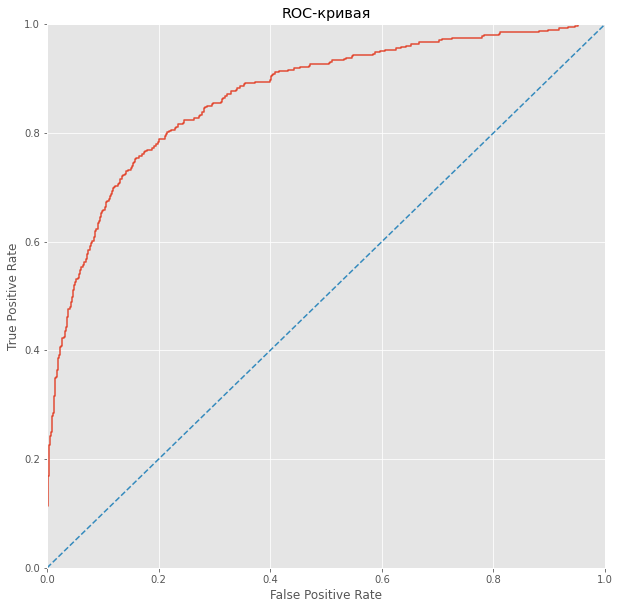

In [101]:
probabilities_test = models[4].predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle="-")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

auc_roc = roc_auc_score(y_test, probabilities_one_test)

Посмотрим, какие признаки для нее важны:

In [102]:
f_imp = pd.DataFrame(
    {"feature": X_test.columns, "importance": models[4].feature_importances_}
)
f_imp.sort_values("importance", ascending=False).reset_index(drop=True).head(3)

,feature,importance
0,age,0.3164
1,numofproducts,0.2259
2,balance,0.1156


## Вывод

Обучение различных по своим алгоритмам моделей на тренировочных данных и дальнейшая их проверка на тестовых данных позволяет подыскать наиболее подходящую по эффективности модель. Мы убедились в этом, использовав данные клиентов банка и решения об их уходе.  

С помощью этих данных мы получили признаки для обучения модели с целью прогнозирования оттока клиентов. 

Проведя исследование и обучая модели, было установлено, что модель случайного леса из выбранных алгоритмов лучше остальных подходит для решения нашей конкретной задачи. Энерго- и времязатратна по оптимизации, но довольно эффективна.

При этом, для этой модели наибольший вес для прогнозирования имеют: возраст  клиента, количество продуктов банка, используемых клиентом и баланс счета.